# Lecture 8: Hashing!

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from random import choice
%matplotlib inline

First let's implement a (chained) hash table:

In [2]:
class HashTable:
    # init function for our hash table
    # h is a function that maps a universe U to range(n)
    def __init__(self, h, n):
        self.h = h
        # store n buckets, each of which has a linked list. 
        # I'm just going to implement as python arrays.
        self.buckets = [ [] for i in range(n) ]
        
    def insert(self, x):
        self.buckets[self.h(x)].append(x)
        
    # delete an item in the hash table, if it's in there
    # returns the deleted item, or None if it wasn't found.
    def delete(self,x):
        bucket = self.buckets[self.h(x)]
        # take time O(n) to look for x in the bucket.
        for i in range(len(bucket)):
            if bucket[i] == x:
                return bucket.pop(i)
        return None
    
    # same as delete, but don't remove it when you find it.
    def find(self,x):
        bucket = self.buckets[self.h(x)]
        # take time O(n) to look for x in the bucket.
        for i in range(len(bucket)):
            if bucket[i] == x:
                return bucket[i]  
        return None
        

## Let's define a few of our favorite hash functions.  

### Here's the "last digit" hash function:

In [3]:
def xModn(x,n=10):
    return x%n

In [4]:
print(xModn(52))
print(xModn(3235235))

2
5


### Does this work?

In [5]:
HT = HashTable(xModn, 10) # make a hash table that uses the last digit.

x = 1234567
y = 76554334234
HT.insert(x)

# let's make sure that x is there and y isn't.
if HT.find(x) == x:
    print("successfully found", x, ": GREAT!")
else:
    print("failed to find", x, ": SOMETHING's BROKEN!")
    
    
if HT.find(y) == None:
    print( y, "is not in the hash table", ": GREAT!")
else:
    print( "found", y, "in the hash table", ": SOMETHING's BROKEN!")

successfully found 1234567 : GREAT!
76554334234 is not in the hash table : GREAT!


## How about a uniformly random hash function?

In [6]:
def randomFn(x, n=10):
    return choice(range(n))

In [7]:
print(randomFn(52))
print(randomFn(3235235))

7
6


### Let's make sure that works

In [8]:
HT = HashTable(randomFn, 10) # make a hash table that uses the last digit.

x = 1234567
y = 76554334234
HT.insert(x)

# let's make sure that x is there and y isn't.
if HT.find(x) == x:
    print("successfully found", x, ": GREAT!")
else:
    print("failed to find", x, ": SOMETHING's BROKEN!")
    
    
if HT.find(y) == None:
    print( y, "is not in the hash table", ": GREAT!")
else:
    print( "found", y, "in the hash table", ": SOMETHING's BROKEN!")

failed to find 1234567 : SOMETHING's BROKEN!
76554334234 is not in the hash table : GREAT!


# Whoops!  

### What went wrong?
.

.

.

.

(Think about it)

.

.

.

.

.

(Still thinking)

.

.

.

.

.
## The problem is that this isn't a function! 
It takes different values different times it's called.
So we can't use it to look up a stored element.

In [9]:
print(randomFn(52))
print(randomFn(3235235))

8
9


In [10]:
print(randomFn(52))
print(randomFn(3235235))

6
8


### In order to make it a function, we need to keep track of all of the values!

In [11]:
# generate a uniformly random hash function from range(M) to range(n).
def generateUniformlyRandomHashFunction(M, n=10):
    fnTable = [ None for i in range(M) ]
    for x in range(M):
        fnTable[x] = choice(range(n))
    def randomFn(x):
        return fnTable[x]
    return randomFn

Let's try this again...

In [12]:
randomFnTake2 = generateUniformlyRandomHashFunction(1000, 10)

In [13]:
print(randomFnTake2(52))
print(randomFnTake2(324))

2
7


In [14]:
print(randomFnTake2(52))
print(randomFnTake2(324))

2
7


In [16]:
HT = HashTable(randomFnTake2, 10) # make a hash table that uses our random function.

x = 123
y = 76
HT.insert(x)

# let's make sure that x is there and y isn't.
if HT.find(x) == x:
    print("successfully found", x, ": GREAT!")
else:
    print("failed to find", x, ": SOMETHING's BROKEN!")
    
    
if HT.find(y) == None:
    print( y, "is not in the hash table", ": GREAT!")
else:
    print( "found", y, "in the hash table", ": SOMETHING's BROKEN!")

successfully found 123 : GREAT!
76 is not in the hash table : GREAT!


### What's the problem?

The above seems like it works...when M=1000.  Say that I wanted to hash all possible twitter hashtags.  (Suppose that a hashtag is allowed to be as long as a tweet used to be -- 140 characters).  There are 128 ASCII symbols, so the number of possible hashtags is (128)^(140)

In [ ]:
# Note: you can try running this if you want...but it will take a VERY long time...

randomFnForHashtags = generateUniformlyRandomHashFunction(128**140, 10)

# Universal Hash Families

For a completely random hash function, we chose a function at random from the set {all of the functions}

Instead, we could choose a function at random from a smaller set.

### Not a good hash family

Here's the example from the slides

In [17]:
def leastSigDig(x,n=10):
    return x%n

def mostSigDig(x,n=10):
    if x == 0:
        return 0
    while x > 0:
        last = x%n
        x = (x/n).__trunc__()
    return last

# our hash family will be { leastSigDig, mostSigDig }


### A better hash family

This is the universal hash family we saw in class

In [18]:
def generateUniversalHashFn(a,b,p,n=10):
    # now define f.
    def f(x):
        r = (a*x + b) % p
        return r % n
    return f        

# our hash family is the set { generateUniversalHAshFn(a,b,p) : a=1,..,p-1, b=0,...,p-1 }


### Let's compare collision probabilities!

Small collision probability is good, it means the buckets of our hash table never get too full.

In [19]:
# Estimates collision probabilities
# hashFamilyFn is a method that returns a function at random from a hash family
# M is the size of the universe
def getCollisionProbabilities(hashFamilyFn, M, trials=100):
    data = []
    for x in range(M):
        for y in range(x+1, M):
            countxy = 0
            # let's estimate collision probability
            for t in range(trials):
                h = hashFamilyFn() # draw a random hash function
                if h(x) == h(y):
                    countxy += 1
            data.append(countxy/trials)
    return data

In [20]:
# Let's hash 100 things into 10 buckets.
M = 100
n = 10
p = 101 # this is the smallest prime larger than 100

# here are our hash families
def drawFromBadHashFamily():
    return choice( [ leastSigDig, mostSigDig ] )

def drawFromGoodHashFamily():
    a = choice( range(1, p))
    b = choice(range(p))
    return generateUniversalHashFn(a,b,p)

# this is the benchmark, although the storage is prohibitive:
def drawFromBestHashFamily():
    return generateUniformlyRandomHashFunction(M,n)

In [21]:
# get some data
dataBad = getCollisionProbabilities(drawFromBadHashFamily, M, trials=100)
dataGood = getCollisionProbabilities(drawFromGoodHashFamily, M, trials=100)
#dataGreat = getCollisionProbabilities(drawFromBestHashFamily, M, trials=100)
# As we saw before, this last one takes a really long time!

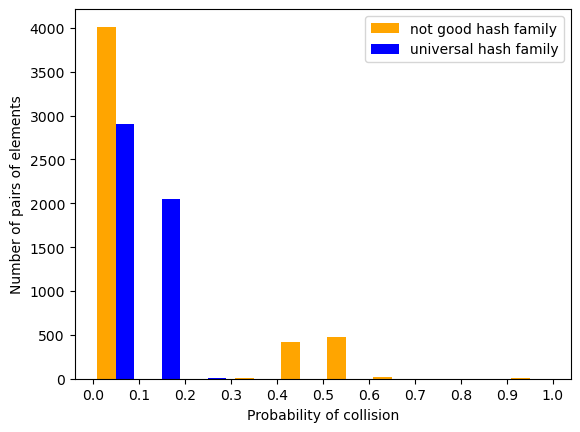

In [22]:
counts, bins, patchs = plt.hist([dataBad,dataGood], color=["orange","blue"], label=["not good hash family", "universal hash family"], bins=10)
plt.legend()
plt.xticks(bins)
plt.xlabel("Probability of collision")
plt.ylabel("Number of pairs of elements")
plt.show()